In [1035]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from config import Config as c

In [1036]:
import matplotlib.pyplot as plt
import json
import pandas as pd

In [1037]:
import os
import random
from pathlib import Path
import shutil

In [1281]:
ham_dataset_dir = 'ham_minified'
mel_source_dir = 'mel_src'
mel_test_num = 200
mel_gen_num = 800
batch_size = 48
seed = 42

In [1282]:
IMG_SIZE = (224, 224)

In [1283]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Preprocessing and Augmentation

In [1284]:
# images = list(os.walk(ham_dataset_dir + '/mel'))[0][2]
# images_to_save = random.sample(images, mel_test_num)
# images_to_delete = [image for image in images if image not in images_to_save]
# for image_to_delete in images_to_delete:
#     path = Path(f'{ham_dataset_dir}/mel/{image_to_delete}')
#     path.unlink(missing_ok=False)

In [1285]:
images = list(os.walk(ham_dataset_dir + '/mel'))[0][2]
for image_to_delete in images:
    path = Path(f'{ham_dataset_dir}/mel/{image_to_delete}')
    path.unlink(missing_ok=False)

In [1286]:
images = list(os.walk(mel_source_dir + '/mel_true'))[0][2]
mel_images = random.sample(images, mel_test_num)
for true_image in mel_images:
    shutil.copy(mel_source_dir + '/mel_true/' + true_image, ham_dataset_dir + '/mel/' + true_image)

In [1287]:
val_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                          labels='inferred', label_mode='categorical', shuffle=True, subset='validation', image_size=IMG_SIZE,
                                                          batch_size=batch_size,  seed=seed)

Found 2813 files belonging to 4 classes.
Using 843 files for validation.


In [1288]:
images = list(os.walk(mel_source_dir + '/gen_data'))[0][2]
gen_images = random.sample(images, mel_gen_num)
for gen_image in gen_images:
    shutil.copy(mel_source_dir + '/gen_data/' + gen_image, ham_dataset_dir + '/mel/' + gen_image)

In [1289]:
train_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                            labels='inferred', label_mode='categorical', shuffle=True, subset='training', image_size=IMG_SIZE,
                                                            batch_size=batch_size, seed=seed)

Found 3613 files belonging to 4 classes.
Using 2530 files for training.


In [1290]:
# class_names = train_ds.class_names

# plt.figure(figsize=(10, 10))

# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [1291]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [1292]:
val_labels = [np.argmax(y.numpy(), axis=1) for x, y in list(val_ds)]
val_labels = np.concatenate(val_labels, axis=None)

test_labels = [np.argmax(y.numpy(), axis=1) for x, y in list(test_ds)]
test_labels = np.concatenate(test_labels, axis=None)

In [1293]:
print('Size of validation dataset: %d' % len(val_labels))
print('Size of test dataset: %d' % len(test_labels))

Size of validation dataset: 411
Size of test dataset: 432


In [1294]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 9
Number of test batches: 9


In [1295]:
# train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# val_ds = val_ds.map(lambda x, y: (rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

In [1296]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(0.4,0.4),
  tf.keras.layers.RandomContrast(0.3)
])

In [1297]:
# for image, _ in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')

In [1298]:
# rescale = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)

### Class Weight Stuff

In [1299]:
train_ds_single_batch = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                                         labels='inferred', shuffle=True, subset='training', image_size=(256, 256),
                                                                         batch_size=1, seed=seed)

Found 3613 files belonging to 4 classes.
Using 2530 files for training.


In [1300]:
y = np.array([label.numpy()[0] for _, label in train_ds_single_batch])
class_weights_list = compute_class_weight('balanced', classes=np.unique(y), y=y)
print(class_weights_list)
class_weights = {}

[1.74242424 0.82356771 0.89210155 0.91666667]


In [1301]:
for i in range(len(class_weights_list)):
    class_weights[i] = class_weights_list[i]

### Define Model

In [1302]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [1303]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(48, 7, 7, 2048)


In [1304]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_57[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [1305]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(48, 2048)


In [1306]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(48, 4)


In [1307]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [1308]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [1309]:
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.categorical_crossentropy,
#               metrics=['accuracy'])

### Fine-Tune Model

In [1310]:
# Make bottom layers trainable
base_model.trainable = True

In [1311]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


In [1312]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [1313]:
# model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [1314]:
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_29 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_28  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_28 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_28  (None, 2048)             0  

In [1315]:
len(model.trainable_variables)

92

### Model Training

In [1316]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_ds)

9/9 [==============================] - 2s 90ms/step - loss: 1.5800 - accuracy: 0.2555


In [1317]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.58
initial accuracy: 0.26


In [1318]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50
53/53 [==============================] - 17s 245ms/step - loss: 0.8753 - accuracy: 0.6466 - val_loss: 0.8487 - val_accuracy: 0.6667
Epoch 2/50
53/53 [==============================] - 12s 225ms/step - loss: 0.6318 - accuracy: 0.7565 - val_loss: 0.7192 - val_accuracy: 0.7105
Epoch 3/50
53/53 [==============================] - 12s 227ms/step - loss: 0.5460 - accuracy: 0.7976 - val_loss: 0.6698 - val_accuracy: 0.7348
Epoch 4/50
53/53 [==============================] - 12s 228ms/step - loss: 0.5096 - accuracy: 0.8004 - val_loss: 0.6353 - val_accuracy: 0.7567
Epoch 5/50
53/53 [==============================] - 12s 228ms/step - loss: 0.4691 - accuracy: 0.8198 - val_loss: 0.5886 - val_accuracy: 0.7543
Epoch 6/50
53/53 [==============================] - 12s 228ms/step - loss: 0.4475 - accuracy: 0.8209 - val_loss: 0.5179 - val_accuracy: 0.7908
Epoch 7/50
53/53 [==============================] - 12s 227ms/step - loss: 0.4151 - accuracy: 0.8403 - val_loss: 0.4861 - val_accuracy: 0.8078

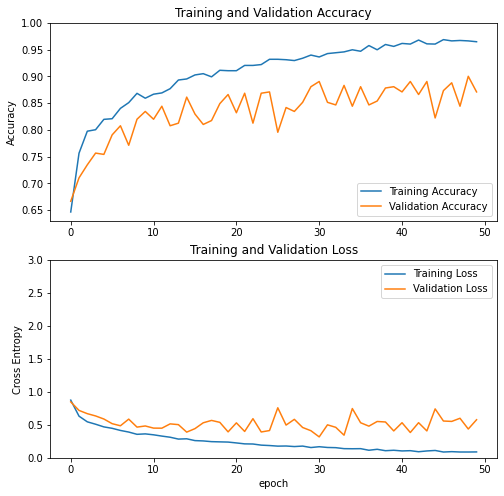

In [1319]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('plots/da_ft_history_mel_' + str(mel_test_num) + '_gen_' + str(mel_gen_num) + '.pdf')

In [1320]:
plt.show()

In [1321]:
with open('history/da_ft_history_mel_' + str(mel_test_num) + '_gen_' + str(mel_gen_num) + '.json', 'w') as f:
        json.dump(history.history, f, indent=4)

### Evaluation, Test Set

In [1322]:
test_list = list(test_ds)

In [1323]:
preds = []
labels = []

for batch_num in range(len(test_list)):
    image_batch, label_batch = test_list[batch_num]
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    this_pred = model.predict_on_batch(image_batch)
    this_classes = np.argmax(this_pred, axis=1)
    
    pred = tf.keras.utils.to_categorical(this_classes, num_classes=4)
    
    y_test_non_category = [ np.argmax(t) for t in label_batch ]
    y_predict_non_category = [ np.argmax(t) for t in pred ]
    
    labels.extend(y_test_non_category)
    preds.extend(y_predict_non_category)

In [1324]:
label_names = sorted(os.listdir(ham_dataset_dir))

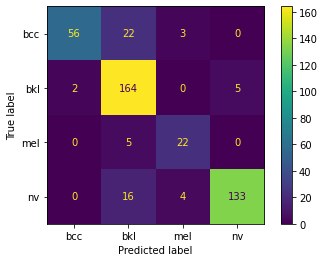

In [1325]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=label_names)
disp.plot()
plt.savefig('plots/da_ft_confmat_mel_' + str(mel_test_num) + '_gen_' + str(mel_gen_num) + '.pdf')

In [1326]:
plt.show()

In [1327]:
print("Model tested on a total of {} images".format(len(labels)))

Model tested on a total of 432 images


### Precision Recall Metrics

In [1328]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [1329]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=label_names))


Accuracy: 0.87

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.87
Macro Recall: 0.83
Macro F1-score: 0.84

Weighted Precision: 0.88
Weighted Recall: 0.87
Weighted F1-score: 0.87

Classification Report

              precision    recall  f1-score   support

         bcc       0.97      0.69      0.81        81
         bkl       0.79      0.96      0.87       171
         mel       0.76      0.81      0.79        27
          nv       0.96      0.87      0.91       153

    accuracy                           0.87       432
   macro avg       0.87      0.83      0.84       432
weighted avg       0.88      0.87      0.87       432



In [1330]:
report_dict = classification_report(labels, preds, target_names=label_names, output_dict=True)
report_data = pd.DataFrame(report_dict)
report_data.to_csv('reports/da_ft_report_mel_'+ str(mel_test_num) + '_gen_' + str(mel_gen_num) + '.csv')

In [1331]:
report = pd.read_csv('reports/da_ft_report_mel_'+ str(mel_test_num) + '_gen_' + str(mel_gen_num) + '.csv')

In [1332]:
print(report)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.965517    0.792271   0.758621    0.963768  0.868056   
1     recall   0.691358    0.959064   0.814815    0.869281  0.868056   
2   f1-score   0.805755    0.867725   0.785714    0.914089  0.868056   
3    support  81.000000  171.000000  27.000000  153.000000  0.868056   

    macro avg  weighted avg  
0    0.870044      0.883390  
1    0.833630      0.868056  
2    0.843321      0.867401  
3  432.000000    432.000000  


In [1333]:
report200_0 = pd.read_csv('reports/da_ft_report_mel_200_gen_0.csv')
report200_100 = pd.read_csv('reports/da_ft_report_mel_200_gen_100.csv')
report200_200 = pd.read_csv('reports/da_ft_report_mel_200_gen_200.csv')
report200_300 = pd.read_csv('reports/da_ft_report_mel_200_gen_300.csv')
report200_400 = pd.read_csv('reports/da_ft_report_mel_200_gen_400.csv')
report200_500 = pd.read_csv('reports/da_ft_report_mel_200_gen_500.csv')
report200_600 = pd.read_csv('reports/da_ft_report_mel_200_gen_600.csv')
report200_700 = pd.read_csv('reports/da_ft_report_mel_200_gen_700.csv')
report200_800 = pd.read_csv('reports/da_ft_report_mel_200_gen_800.csv')

In [1334]:
print(report200_0)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.914286    0.784314   0.421053    0.913669  0.831019   
1     recall   0.790123    0.935673   0.296296    0.830065  0.831019   
2   f1-score   0.847682    0.853333   0.347826    0.869863  0.831019   
3    support  81.000000  171.000000  27.000000  153.000000  0.831019   

    macro avg  weighted avg  
0    0.758330      0.831793  
1    0.713039      0.831019  
2    0.729676      0.826534  
3  432.000000    432.000000  


In [1335]:
print(report200_100)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.885714    0.893082   0.333333    0.962687  0.824074   
1     recall   0.765432    0.830409   0.851852    0.843137  0.824074   
2   f1-score   0.821192    0.860606   0.479167    0.898955  0.824074   
3    support  81.000000  171.000000  27.000000  153.000000  0.824074   

    macro avg  weighted avg  
0    0.768704      0.881368  
1    0.822708      0.824074  
2    0.764980      0.842958  
3  432.000000    432.000000  


In [1336]:
print(report200_200)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.911765    0.834225   0.628571    0.950704  0.868056   
1     recall   0.765432    0.912281   0.814815    0.882353  0.868056   
2   f1-score   0.832215    0.871508   0.709677    0.915254  0.868056   
3    support  81.000000  171.000000  27.000000  153.000000  0.868056   

    macro avg  weighted avg  
0    0.831316      0.877163  
1    0.843720      0.868056  
2    0.832164      0.869520  
3  432.000000    432.000000  


In [1337]:
print(report200_300)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.950820    0.821990   0.700000    0.906250  0.865741   
1     recall   0.716049    0.918129   0.518519    0.947712  0.865741   
2   f1-score   0.816901    0.867403   0.595745    0.926518  0.865741   
3    support  81.000000  171.000000  27.000000  153.000000  0.865741   

    macro avg  weighted avg  
0    0.844765      0.868363  
1    0.775102      0.865741  
2    0.801642      0.861892  
3  432.000000    432.000000  


In [1338]:
print(report200_400)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.909091    0.905882   0.750000    0.919255  0.902778   
1     recall   0.864198    0.900585   0.666667    0.967320  0.902778   
2   f1-score   0.886076    0.903226   0.705882    0.942675  0.902778   
3    support  81.000000  171.000000  27.000000  153.000000  0.902778   

    macro avg  weighted avg  
0    0.871057      0.901477  
1    0.849692      0.902778  
2    0.859465      0.901648  
3  432.000000    432.000000  


In [1339]:
print(report200_500)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.941176    0.754717   0.666667    0.925676  0.831019   
1     recall   0.592593    0.935673   0.518519    0.895425  0.831019   
2   f1-score   0.727273    0.835509   0.583333    0.910299  0.831019   
3    support  81.000000  171.000000  27.000000  153.000000  0.831019   

    macro avg  weighted avg  
0    0.822059      0.844723  
1    0.735552      0.831019  
2    0.764104      0.825942  
3  432.000000    432.000000  


In [1340]:
print(report200_600)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.936508    0.865922   0.657143    0.916129  0.877315   
1     recall   0.728395    0.906433   0.851852    0.928105  0.877315   
2   f1-score   0.819444    0.885714   0.741935    0.922078  0.877315   
3    support  81.000000  171.000000  27.000000  153.000000  0.877315   

    macro avg  weighted avg  
0    0.843925      0.883890  
1    0.853696      0.877315  
2    0.842293      0.877181  
3  432.000000    432.000000  


In [1341]:
print(report200_700)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.960784    0.817259   0.617647    0.940000  0.861111   
1     recall   0.604938    0.941520   0.777778    0.921569  0.861111   
2   f1-score   0.742424    0.875000   0.688525    0.930693  0.861111   
3    support  81.000000  171.000000  27.000000  153.000000  0.861111   

    macro avg  weighted avg  
0    0.833923      0.875165  
1    0.811451      0.861111  
2    0.809160      0.858212  
3  432.000000    432.000000  


In [1342]:
print(report200_800)

  Unnamed: 0        bcc         bkl        mel          nv  accuracy  \
0  precision   0.965517    0.792271   0.758621    0.963768  0.868056   
1     recall   0.691358    0.959064   0.814815    0.869281  0.868056   
2   f1-score   0.805755    0.867725   0.785714    0.914089  0.868056   
3    support  81.000000  171.000000  27.000000  153.000000  0.868056   

    macro avg  weighted avg  
0    0.870044      0.883390  
1    0.833630      0.868056  
2    0.843321      0.867401  
3  432.000000    432.000000  
